In [6]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

In [8]:
#Question 1. Downloading the data 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [10]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [11]:
#Question 2. Computing duration

In [12]:
df.duration.std()

42.59435124195458

In [13]:
# Question 3. Dropping outliers 

In [14]:
prev_len = len(df)

In [15]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [16]:
print(f'Number of records remaining: {1-(prev_len - len(df))/prev_len}')

Number of records remaining: 0.9812202822125979


In [17]:
# Question 4. One-hot encoding 

In [18]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


In [19]:
target = 'duration'
y_train = df[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.649261927686161


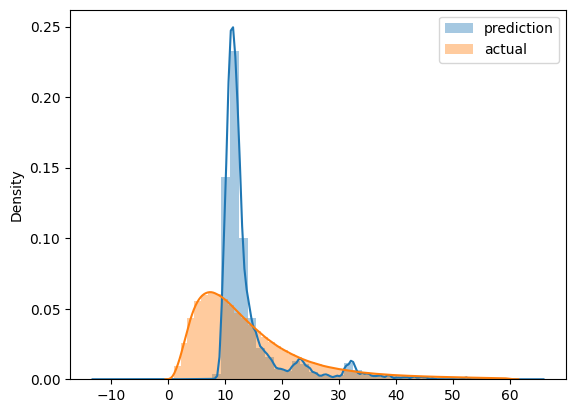

In [21]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

In [22]:
# Question 6. Evaluating the model. RMSE on validation 

In [23]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [24]:
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [25]:
df_train = read_dataframe('../data/yellow_tripdata_2023-01.parquet')

In [26]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
X_val.shape, X_train.shape

((2855951, 516), (3009173, 516))

In [28]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [29]:
with mlflow.start_run():
    mlflow.set_tag("developer", "criticism")
    mlflow.log_param("train-data-path", "../data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "../data/yellow_tripdata_2023-02.parquet")
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

In [30]:
y_val_pred = lr.predict(X_val)

mean_squared_error(y_val, y_val_pred, squared=False)

7.820203893965551

In [31]:
#######################################################


In [64]:
import pickle
with open(f"../models/model.bin", "wb") as f_out:
    pickle.dump(lr, f_out)

In [43]:
from mlflow.tracking import MlflowClient
import mlflow


MLFLOW_TRACKING_URI = "sqlite:///../data/mlflow.db"

In [71]:
mlflow.set_experiment("new-experiment-5")
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

2024/05/27 19:53:19 INFO mlflow.tracking.fluent: Experiment with name 'new-experiment-5' does not exist. Creating a new experiment.


In [35]:


import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [82]:
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(current_working_directory)


# Log artifact with a corrected path
artifact_path = "models_pickle"
local_path = parent_directory + "/models/model.bin"


In [74]:
parent_directory

'/Users/amrit/Documents/Projects/DataTalkClub/cohort/mlops-Zoomcamp'

In [83]:
with mlflow.start_run():
    mlflow.set_tag("developer", "criticism")
    mlflow.log_param("train-data-path", "../data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "../data/yellow_tripdata_2023-02.parquet")

    # alpha = 0.1
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    
    rmse = mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)
    
    mlflow.log_artifact(local_path=parent_directory+"/models/model.bin", artifact_path=artifact_path)

In [84]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [85]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [86]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.09889                                                                           
[1]	validation-rmse:6.80223                                                                           
[2]	validation-rmse:5.97879                                                                           
[3]	validation-rmse:5.46509                                                                           
[4]	validation-rmse:5.16092                                                                           
[5]	validation-rmse:4.97662                                                                           
[6]	validation-rmse:4.86732                                                                           
[7]	validation-rmse:4.79720                                                                           
[8]	validation-rmse:4.75263                                                                           
[9]	validation-rmse:4.72542                                              

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        